# How to get cryptocurrency prices via Python (Bitcoin, Ethereum)

**Date:** Friday, December 6th, 2024  
**URL:** https://www.youtube.com/watch?v=w6JqNyHNQnQ

## Notes

- `yfinance` has changed since this video was made, so the code in the video is obsolete
- `pandas_datareader` isn't really necessary

## Code

### Imports

In [1]:
from datetime import datetime, timedelta

import pandas as pd
import yfinance as yf
# from pandas_datareader import data as pdr

### Fetch data from Yahoo Finance

In [20]:
symbol = "BTC-CAD"
# symbol = "BTC-USD"

run_dt = datetime.now().astimezone()
date_from = (run_dt - timedelta(days=1)).date()
date_thru = datetime.now().date()

df = yf.download(symbol, start=date_from, end=date_thru, interval="1d", multi_level_index=False)
df.tail(3)


*********************100%***********************]  1 of 1 completed

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2024-12-07,141472.75,141472.75,144396.4375,135361.15625,136092.71875,133847057868


### Adjust Columns
- Drop `Adj Close`
- Convert to lower case and remove spaces
- Shorten column names where practical
- Add column for symbol
- Reorder

In [21]:
# Add column for symbol
df.loc[:,"symbol"] = symbol
# Rename index & columns
df.index.name = "date_id"
df.rename(columns={"Close": "price",}, inplace=True)
# Only keep symbol and closing price
df = df[["symbol", "price"]]
df.tail(3)

,symbol,price
date_id,,
2024-12-07,BTC-CAD,141472.75


### Connect to Database

In [4]:
import sqlalchemy as sa
from sqlalchemy import create_engine, text

In [5]:
db_url = "postgresql+psycopg://localhost/patrick"
db_schema = "btc_rates"

engine = create_engine(db_url, echo=False)

@sa.event.listens_for(engine, "connect", insert=True)
def set_search_path(dbapi_connection, connection_record):
    """
    Set schema search path in database
    """
    sql = f"SET SESSION search_path TO {db_schema},public;"
    existing_autocommit = dbapi_connection.autocommit
    dbapi_connection.autocommit = True
    cursor = dbapi_connection.cursor()
    cursor.execute(sql)
    cursor.close()
    dbapi_connection.autocommit = existing_autocommit

### Save Data

In [6]:
df.to_sql("dt_daily", con=engine, schema=db_schema, if_exists="append")

-1

<Axes: xlabel='date_id'>

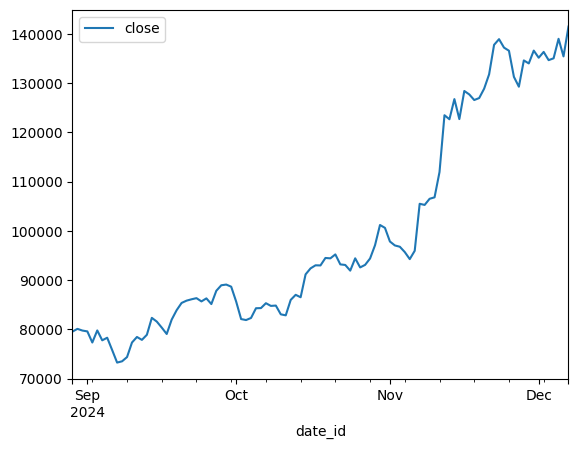

In [19]:
df.plot()